[Reference](https://towardsdatascience.com/speed-up-your-algorithms-part-1-pytorch-56d8a4ae7051)

In [1]:
import torch
torch.cuda.is_available()

True

In [7]:
import torch
!pip install pycuda
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU
# Tesla K80

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4537347 sha256=5c620d0c0c9201f52c22b395c19c8ebcfa0b4b5e0446caac8d34712f4a7e36f1
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2020.4-py2.py3-none-any.whl size=67175 sha256=75ca53b550d6551a0f0af6a99605b976e91841b034454dead2904f349b3070d8
  Stored in directory: /root/.cache/pip/wheels/5e/20/0b/fac51840734b2587ecc239a62522b164c374e929e2c9be66c5
Successfully built pycuda pytools


'Tesla K80'

In [8]:
# A simple class to know about your cuda devices
import pycuda.driver as cuda
import pycuda.autoinit # Necessary for using its functions
cuda.init() # Necesarry for using its functions

class aboutCudaDevices():
    def __init__(self):
        pass
    
    def num_devices(self):
        """Return number of devices connected."""
        return cuda.Device.count()
    
    def devices(self):
        """Get info on all devices connected."""
        num = cuda.Device.count()
        print("%d device(s) found:"%num)
        for i in range(num):
            print(cuda.Device(i).name(), "(Id: %d)"%i)
            
    def mem_info(self):
        """Get available and total memory of all devices."""
        available, total = cuda.mem_get_info()
        print("Available: %.2f GB\nTotal:     %.2f GB"%(available/1e9, total/1e9))
        
    def attributes(self, device_id=0):
        """Get attributes of device with device Id = device_id"""
        return cuda.Device(device_id).get_attributes()
    
    def __repr__(self):
        """Class representation as number of devices connected and about them."""
        num = cuda.Device.count()
        string = ""
        string += ("%d device(s) found:\n"%num)
        for i in range(num):
            string += ( "    %d) %s (Id: %d)\n"%((i+1),cuda.Device(i).name(),i))
            string += ("          Memory: %.2f GB\n"%(cuda.Device(i).total_memory()/1e9))
        return string

# You can print output just by typing its name (__repr__):
aboutCudaDevices()

1 device(s) found:
    1) Tesla K80 (Id: 0)
          Memory: 12.00 GB

In [9]:
import torch
# Returns the current GPU memory usage by 
# tensors in bytes for a given device
torch.cuda.memory_allocated()
# Returns the current GPU memory managed by the
# caching allocator in bytes for a given device
torch.cuda.memory_cached()

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


0

In [10]:
# Releases all unoccupied cached memory currently held by
# the caching allocator so that those can be used in other
# GPU application and visible in nvidia-smi
torch.cuda.empty_cache()

In [11]:
a = torch.FloatTensor([1., 2.]).cuda()

In [13]:
import torch.nn as nn
sq = nn.Sequential(
         nn.Linear(20, 20),
         nn.ReLU(),
         nn.Linear(20, 4),
         nn.Softmax()
)

In [14]:
model = sq.cuda()

In [15]:
# From the discussions here: discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda
next(model.parameters()).is_cuda

True

In [16]:
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')
cuda2 = torch.device('cuda:2')

In [20]:
x = torch.Tensor([1., 2.]).cuda(cuda0)

In [23]:
x = torch.Tensor([1., 2.]).to(cuda0)
y = torch.Tensor([3., 4.]).to(cuda0)
# This Tensor will be saved on 'cuda2' only
z = x + y

In [24]:
z

tensor([4., 6.], device='cuda:0')

In [25]:
cuda = torch.device('cuda')
s = torch.cuda.Stream()  # Create a new stream.
A = torch.empty((100, 100), device=cuda).normal_(0.0, 1.0)
with torch.cuda.stream(s):
    # because sum() may start execution before normal_() finishes!
    B = torch.sum(A)

In [28]:
model_cpu = nn.Sequential(
         nn.Linear(20, 20),
         nn.ReLU(),
         nn.Linear(20, 4),
         nn.Softmax()
).float()
model_gpu = model.float()
next(model_cpu.parameters()).is_cuda, next(model_gpu.parameters()).is_cuda

(False, True)

In [29]:
cpu_inp = torch.ones((100000, 20), dtype=torch.float32)
gpu_inp = torch.ones((100000, 20), dtype=torch.float32).cuda()

In [30]:
%timeit res = model_cpu(cpu_inp)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


10 loops, best of 3: 24.1 ms per loop


In [31]:
%%timeit 
for i in range(10): # Because we don't have enough memory on GPU
  res = model_gpu(gpu_inp[i*1000:i*1000+1000])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


The slowest run took 7.41 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.28 ms per loop


Text(0.5, 0, 'Model Type')

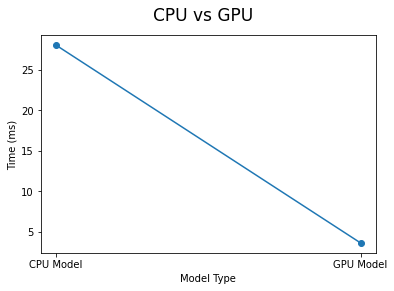

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b"], [28, 3.61], "-o")
ax.set_xticklabels(["CPU Model", "GPU Model"])
fig.suptitle("CPU vs GPU", fontsize=17)
ax.set_ylabel("Time (ms)")
ax.set_xlabel("Model Type")

In [34]:
module =  nn.Sequential(
         nn.Linear(20, 20),
         nn.ReLU(),
         nn.Linear(20, 4),
         nn.Softmax()
).cuda()

inp = torch.ones((30, 20)).cuda()

In [35]:
# Replicate module to devices in device_ids
replicas = nn.parallel.replicate(module, [0])

# Distribute input to devices in device_ids
inputs = nn.parallel.scatter(inp, [0])

# Apply the models to corresponding inputs
outputs = nn.parallel.parallel_apply(replicas, inputs)

# Gather result from all devices to output_device
result = nn.parallel.gather(outputs, 0)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [36]:
result.shape # Output from module

torch.Size([30, 4])

In [37]:
# Or we could have done:
model = nn.DataParallel(model, device_ids=[0])
result = model(inp)
result.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([30, 4])